In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#!conda install -c conda-forge folium

import os
import folium # map rendering library
# Matplotlib and associated plotting modules

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mp
import re
import csv
%matplotlib inline



In [2]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
    #set variables
    radius=1000
    LIMIT=100
    CLIENT_ID = 'SJVNROHFKAQ0CZ5ULIM0V5K5IXUPI2UV1FARMVENUHS3HB4F'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='W1H0JXEDQWHBWX1ZZYT2IXCRTWLGPSNQ2NOGQ5IA4ZKCQKEU' # Foursquare Secret, note there is a daily call quota it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'FM32E0UU4KR1WU4VZIG1F5G1J2XFMKEGNF52UGPTSQ1J1CF1'# Foursquare ID, note there is a daily call quota limit 
    CLIENT_SECRET ='R5SUZ4FBHNDVUMHP15ZKFIKI5VCQBLGPYSFGZY2LYQXMILX2' # Foursquare Secret, note there is a daily call quota it it
    VERSION = '20180605' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()

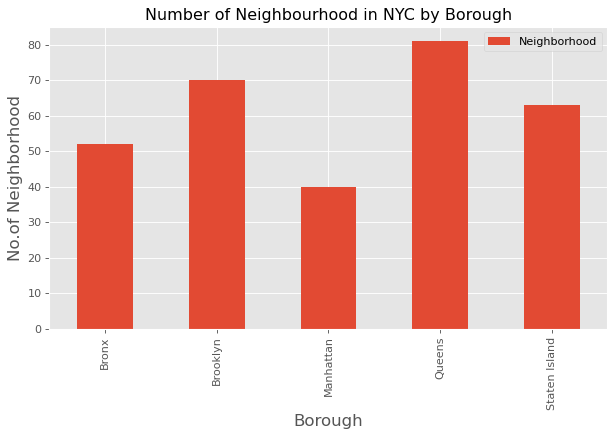

In [7]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 80)
# title
plt.title('Number of Neighbourhood in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Neighborhood', fontsize=15)
#giving a bar plot
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
#legend
plt.legend()
plt.show()

In [26]:
# prepare neighborhood list that contains indian restaurant
column_names=['Borough', 'Neighborhood', 'ID','Name']
yoga_studio_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    yoga_studios=venues[venues['Category']=='Yoga Studio']   
    print('(',count,'/',len(new_york_data),')','Yoga Studios in '+Neighborhood+', '+Borough+':'+str(len(yoga_studios)))
    for gym_detail in yoga_studios.values.tolist():
        id, name , category=gym_detail
        yoga_studio_ny = yoga_studio_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Yoga Studios in Wakefield, Bronx:0
( 2 / 306 ) Yoga Studios in Co-op City, Bronx:0
( 3 / 306 ) Yoga Studios in Eastchester, Bronx:0
( 4 / 306 ) Yoga Studios in Fieldston, Bronx:0
( 5 / 306 ) Yoga Studios in Riverdale, Bronx:0
( 6 / 306 ) Yoga Studios in Kingsbridge, Bronx:1
( 7 / 306 ) Yoga Studios in Marble Hill, Manhattan:1
( 8 / 306 ) Yoga Studios in Woodlawn, Bronx:0
( 9 / 306 ) Yoga Studios in Norwood, Bronx:0
( 10 / 306 ) Yoga Studios in Williamsbridge, Bronx:0
( 11 / 306 ) Yoga Studios in Baychester, Bronx:0
( 12 / 306 ) Yoga Studios in Pelham Parkway, Bronx:1
( 13 / 306 ) Yoga Studios in City Island, Bronx:0
( 14 / 306 ) Yoga Studios in Bedford Park, Bronx:0
( 15 / 306 ) Yoga Studios in University Heights, Bronx:0
( 16 / 306 ) Yoga Studios in Morris Heights, Bronx:0
( 17 / 306 ) Yoga Studios in Fordham, Bronx:0
( 18 / 306 ) Yoga Studios in East Tremont, Bronx:0
( 19 / 306 ) Yoga Studios in West Farms, Bronx:0
( 20 / 306 ) Yoga Studios in High  Bridge, Bronx:0
( 21 /

In [20]:
yoga_studio_ny.head(10)

,Borough,Neighborhood,ID,Name
0,Bronx,Kingsbridge,4baf59e8f964a520a6f93be3,Bikram Yoga
1,Manhattan,Marble Hill,4baf59e8f964a520a6f93be3,Bikram Yoga
2,Bronx,Pelham Parkway,4d5c4633524fa35d8dab4735,Bronx Dahn Yoga Center
3,Brooklyn,Bay Ridge,4b32d9d5f964a520071525e3,Bikram Yoga
4,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga
5,Brooklyn,Greenpoint,55b51009498e4c7fd1fea655,New Love City
6,Brooklyn,Greenpoint,5172d6477043c222fb3a8b97,Maha Rose
7,Brooklyn,Greenpoint,4be738c8bcef2d7fe10606e5,Usha Veda Yoga
8,Brooklyn,Greenpoint,4b79ee03f964a520e31a2fe3,hosh yoga
9,Brooklyn,Greenpoint,56b22714498e31102864ef29,Lucent Yoga


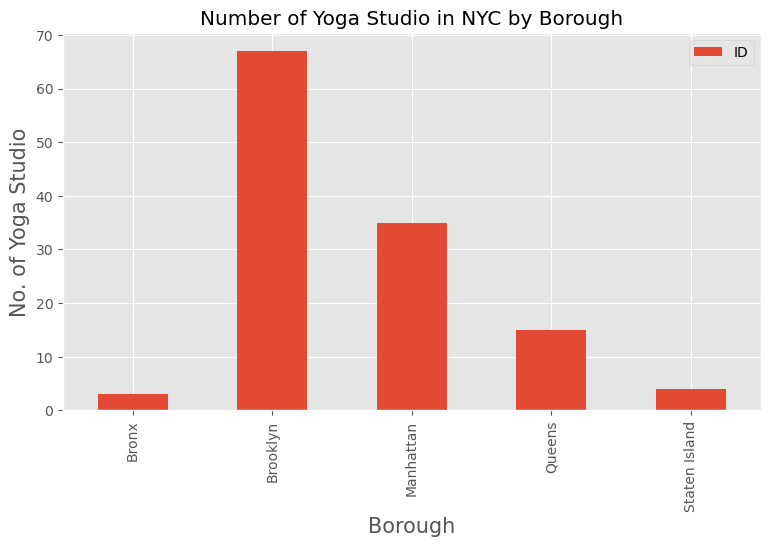

In [21]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Yoga Studio in NYC by Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No. of Yoga Studio', fontsize=15)
#giving a bar plot
yoga_studio_ny.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

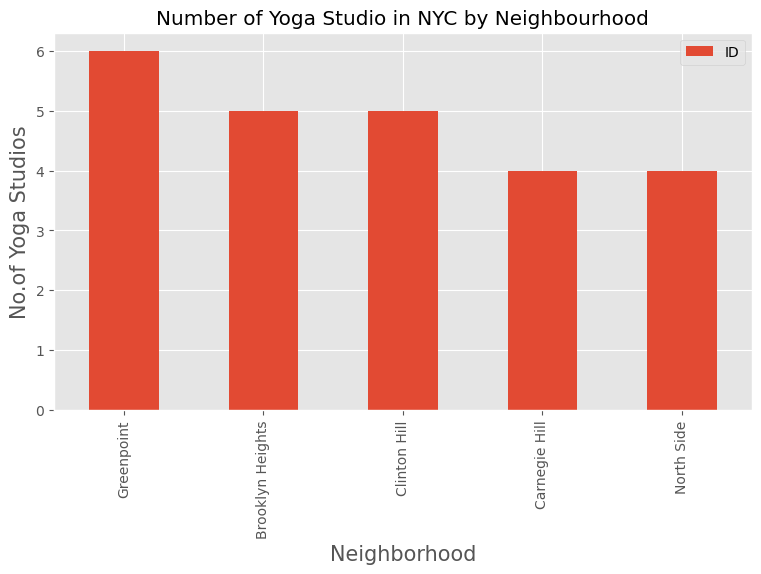

In [22]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Yoga Studio in NYC by Neighbourhood')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Yoga Studios', fontsize=15)
#giving a bar plot
yoga_studio_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [27]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
yoga_studio_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in yoga_studio_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row

    # prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
yoga_studio_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in yoga_studio_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(yoga_studio_ny),')','processed')
    yoga_studio_stats_ny = yoga_studio_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID         Name  Likes  Rating  Tips
0  4baf59e8f964a520a6f93be3  Bikram Yoga     23     8.8     5
( 1 / 124 ) processed
                         ID         Name  Likes  Rating  Tips
0  4baf59e8f964a520a6f93be3  Bikram Yoga     23     8.8     5
( 2 / 124 ) processed
Empty DataFrame
Columns: [ID, Name, Likes, Rating, Tips]
Index: []
No data available for id= 4d5c4633524fa35d8dab4735
( 3 / 124 ) processed
                         ID         Name  Likes  Rating  Tips
0  4b32d9d5f964a520071525e3  Bikram Yoga     18     7.2     5
( 4 / 124 ) processed
                         ID      Name  Likes  Rating  Tips
0  4a9a86dcf964a520cc3120e3  goodyoga     30     9.1     7
( 5 / 124 ) processed
                         ID           Name  Likes  Rating  Tips
0  55b51009498e4c7fd1fea655  New Love City     37     8.9     9
( 6 / 124 ) processed
                         ID       Name  Likes  Rating  Tips
0  5172d6477043c222fb3a8b97  Maha Rose     30     8.8     3
( 7 / 124 ) 

In [28]:
yoga_studio_stats_ny.head()


,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Kingsbridge,4baf59e8f964a520a6f93be3,Bikram Yoga,23,8.8,5
1,Manhattan,Marble Hill,4baf59e8f964a520a6f93be3,Bikram Yoga,23,8.8,5
2,Bronx,Pelham Parkway,0,0,0,0.0,0
3,Brooklyn,Bay Ridge,4b32d9d5f964a520071525e3,Bikram Yoga,18,7.2,5
4,Brooklyn,Greenpoint,4a9a86dcf964a520cc3120e3,goodyoga,30,9.1,7
